In [291]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import MDS
from sklearn.neighbors import DistanceMetric
from sklearn.cluster import KMeans
import warnings

In [268]:
warnings.filterwarnings('ignore')

## Plot functions

In [269]:
def draw_data_distrib(df):
    fig, axes = plt.subplots(3, 2, figsize=(15, 10))
    colors = ['dodgerblue', 'orange', 'deeppink', 'green', 'red', 'purple']
    for feature, ax, color in zip(df, axes.flat, colors):
        sns.distplot(df[feature], ax=ax, color=color) 
        ax.axvline(x=df[feature].median(),
                color='blue',
                ls='--', 
                lw=1.7,
                label='median')

        ax.axvline(x=df[feature].mean(),
                    color='red',
                    ls='--', 
                    lw=1.7,
                    label='mean')
        ax.legend()
    plt.tight_layout()

In [270]:
def draw_corr_mat(df):
    plt.figure(figsize=(12,10))
    cor = df.corr()
    sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
    plt.show()

In [271]:
def draw_boxplot(df):
    fig, axes = plt.subplots(6, 1, figsize=(10, 8))

    for ax, feature in zip(axes, df.columns):
        df[[feature]].plot.box(vert=False, grid=True, ax=ax)
    fig.tight_layout()      

In [293]:
def draw_client_map(X, titles):
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    colors = ['dodgerblue', 'orange', 'red', 'purple']
    for x, ax, color, title in zip(X, axes.flat, colors, titles):
        ax.scatter(x[:,0], x[:,1],
                    c=color, alpha=0.5, marker='o',
                    label='client')
        
        ax.legend(loc='upper right')
        ax.set_title(title)
    plt.tight_layout()

# 1. Exploratory data analysis

Data consis of following parameters:

1 - age (years)

2 - n dependents (amount of dependent people)

3 - income (rubles)

4 - years in the region (years)

5 - car valuation  (USD)

6 - loan amount (hundreds of rubles)

In [273]:
col_names = ['age', 'n dependents', 'income', 
             'years in the region', 'car valuation', 'loan amount']
df = pd.read_excel('data/HW_2_v12.xls', 
                   header=None,
                   names=col_names)

In [274]:
df.head()

,age,n dependents,income,years in the region,car valuation,loan amount
0,42,4,43300,9,44000,437000
1,44,2,12100,13,12000,123000
2,47,3,28700,14,30000,293000
3,40,1,7500,11,7000,74000
4,39,1,9400,11,9000,93000


In [275]:
df.describe()

,age,n dependents,income,years in the region,car valuation,loan amount
count,50.000000,50.000000,50.000000,50.00000,50.000000,50.00000
mean,40.000000,1.980000,19992.000000,10.02000,20060.000000,199960.00000
std,8.045787,0.979171,10002.057747,5.02845,10096.291499,100021.82619
min,24.000000,0.000000,1500.000000,0.00000,0.000000,4000.00000
25%,35.000000,1.250000,12600.000000,6.00000,13000.000000,126500.00000
50%,40.000000,2.000000,17900.000000,10.00000,18500.000000,183000.00000
75%,46.000000,2.750000,29075.000000,14.00000,29750.000000,293000.00000
max,56.000000,4.000000,43300.000000,19.00000,44000.000000,437000.00000


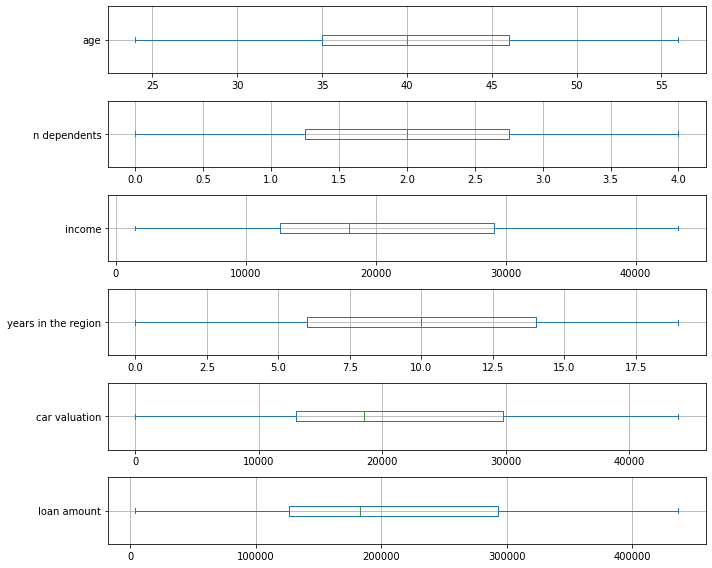

In [11]:
draw_boxplot(df)                                                                  

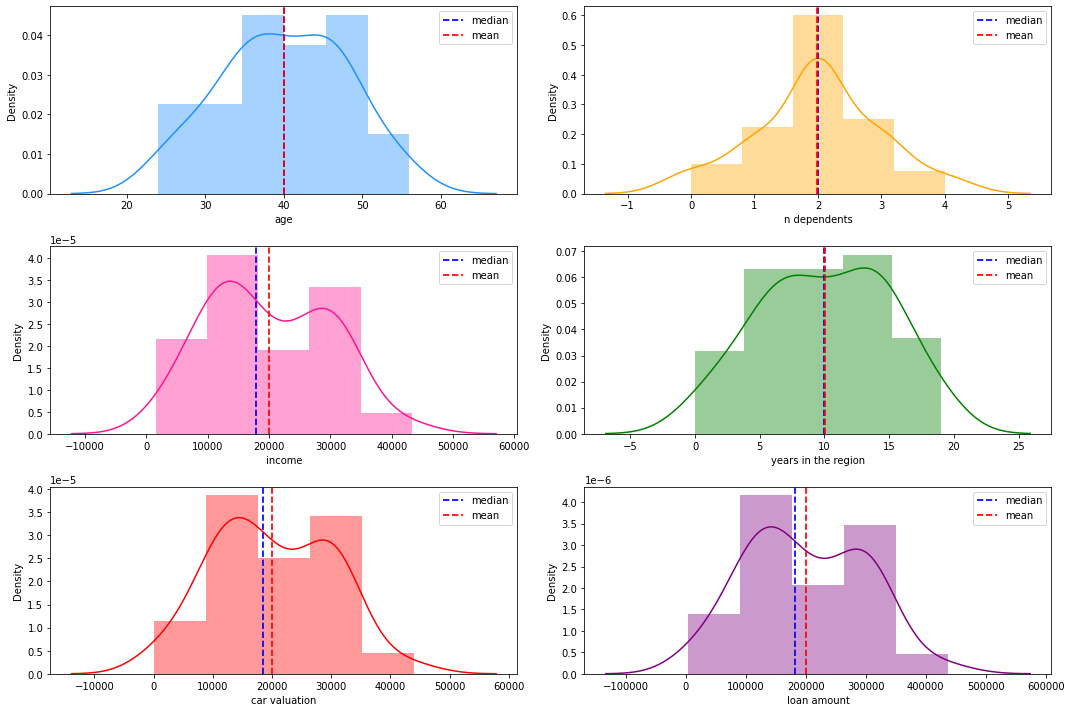

In [12]:
draw_data_distrib(df)

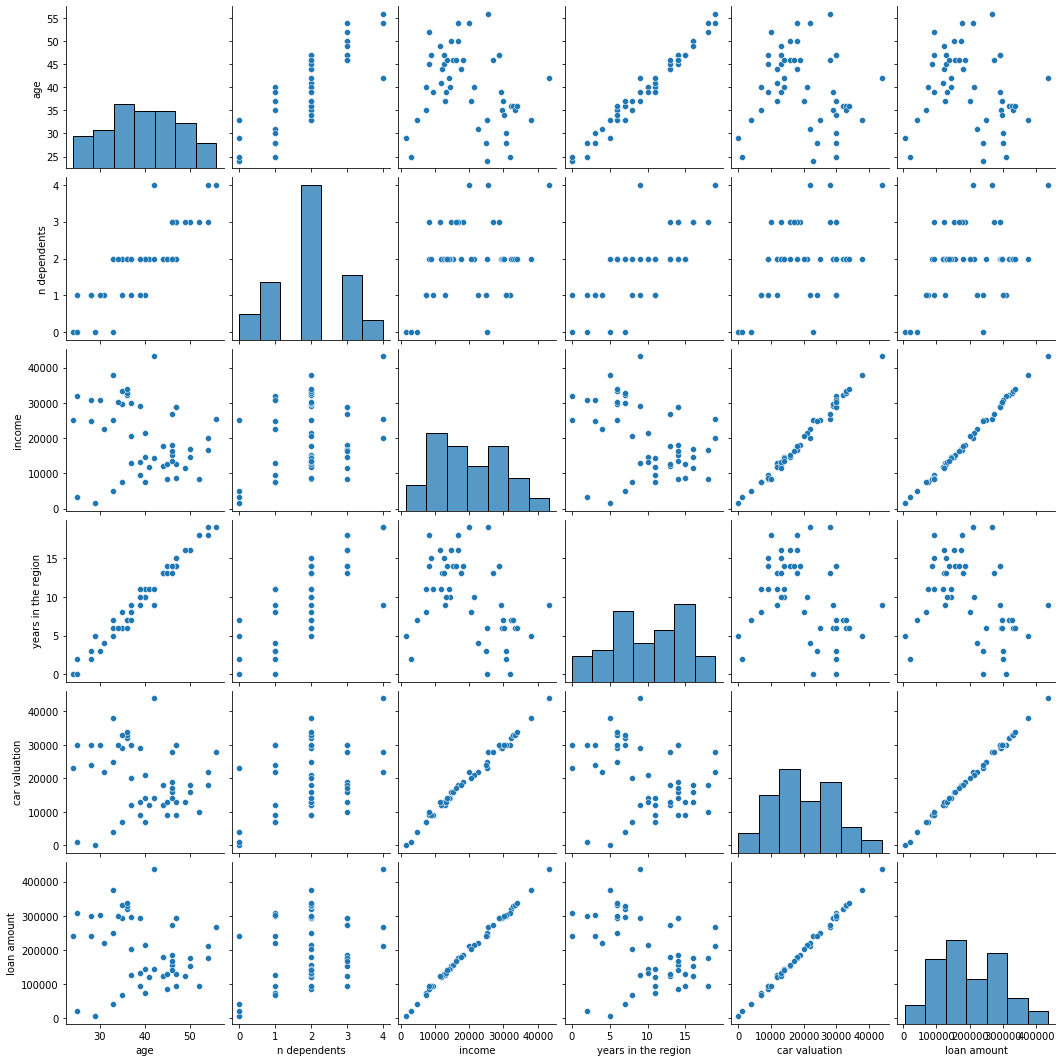

In [13]:
sns.pairplot(df)

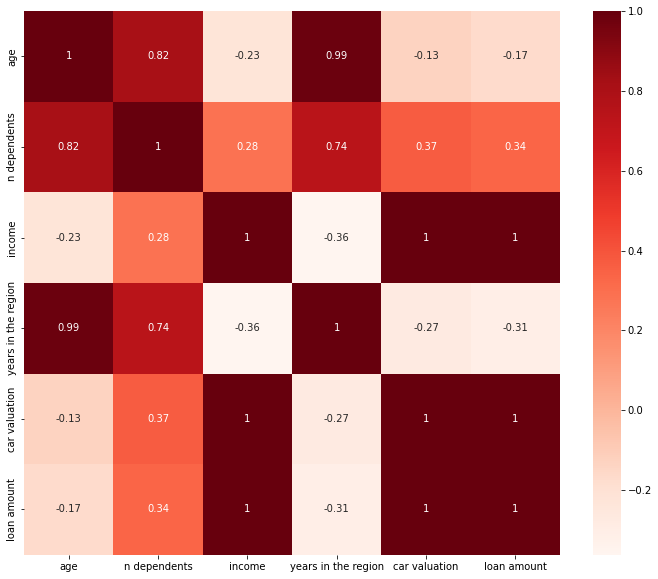

In [64]:
draw_corr_mat(df)

**There is the possibility of successful dimensionality reduction since some variables strongly correlate with each other, for example:**
- Age and years in the region
- Income with car valuation and loan amount
- Car valuation with income 

# 2. Dimension reduction with PCA

> **1. Выполнить центрирование данных и такую нормировку, что евклидова норма каждого признака равна 1 (полученная матрица обозначается через Z).**

In [276]:
import numpy as np
import pandas as pd

#### **Normalize data**

In [298]:
df_normalized = df - df.mean(axis=0)

In [299]:
df_normalized = (df_normalized) / np.sqrt(df_normalized.pow(2).sum(axis=0))

In [300]:
df_normalized.describe()

,age,n dependents,income,years in the region,car valuation,loan amount
count,5.000000e+01,5.000000e+01,5.000000e+01,5.000000e+01,5.000000e+01,5.000000e+01
mean,3.053113e-18,2.810252e-18,-5.551115e-19,1.249001e-17,1.110223e-18,2.220446e-18
std,1.428571e-01,1.428571e-01,1.428571e-01,1.428571e-01,1.428571e-01,1.428571e-01
min,-2.840883e-01,-2.888742e-01,-2.641171e-01,-2.846660e-01,-2.838383e-01,-2.798818e-01
25%,-8.877760e-02,-1.065041e-01,-1.055783e-01,-1.142073e-01,-9.989524e-02,-1.049200e-01
50%,0.000000e+00,2.917921e-03,-2.987957e-02,-5.681956e-04,-2.207317e-02,-2.422328e-02
75%,1.065331e-01,1.123399e-01,1.297304e-01,1.130709e-01,1.371083e-01,1.328853e-01
max,2.840883e-01,2.947100e-01,3.329029e-01,2.551198e-01,3.387382e-01,3.385547e-01


#### **Check that l1-norm is equal to `1` across columns**

In [301]:
for norm_value, column_name in zip(np.linalg.norm(df_normalized, axis=0), df_normalized.columns):
    print(f"The L1 Norm for {column_name} = {round(norm_value)}")
    assert round(norm_value) == 1

The L1 Norm for age = 1
The L1 Norm for n dependents = 1
The L1 Norm for income = 1
The L1 Norm for years in the region = 1
The L1 Norm for car valuation = 1
The L1 Norm for loan amount = 1


>**2. Найти SVD разложение матрицы Z (матрицы U, S, V). Докажите, что при выбранной нормировке, коэффициенты разложения столбцов матрицы Z по скрытым факторам являются корреляциями этих столбцов и скрытых факторов**.

In [302]:
# SVD decomposition 
U, S, V_transposed = np.linalg.svd(df_normalized, full_matrices=False)

We set `full_matrices` equal to `False` because we know that:

$ Z_{nxm} = U_{nxn} * S_{nxm} * V^T_{mxm} = \sigma_1 * u_1 * v^T_1 + \dots +\sigma_p * u_p * v^T_p $ 

where: $ p = min(n, m) $  

In [303]:
print(f"Z_{df_normalized.shape} = U_{U.shape} * S_{S.shape} * V_{V_transposed.shape}")

Z_(50, 6) = U_(50, 6) * S_(6,) * V_(6, 6)


In [304]:
S

array([1.81222664, 1.62751993, 0.25303706, 0.04998986, 0.02184332,
       0.00309906])

**Lets proof  that svd coeffients of Z are equal to correlation between Z and U(latent factors) columns**

In [307]:
svd_coefficients = np.matmul(np.diag(S), V_transposed)

In [308]:
np.ravel(svd_coefficients)

array([-4.33182037e-01,  8.27900930e-02,  9.75604712e-01, -5.57856186e-01,
        9.50266180e-01,  9.61067447e-01,  8.95490617e-01,  9.75871782e-01,
        2.16353606e-01,  8.23494614e-01,  3.08398602e-01,  2.73001796e-01,
       -9.60109585e-02,  2.02036492e-01, -3.60162698e-02, -9.70508840e-02,
       -3.92089722e-02, -4.16835216e-02, -3.50731916e-02,  1.05975507e-03,
       -7.82652597e-04,  3.50653868e-02,  6.07939467e-03, -7.62542116e-04,
       -1.28091461e-03,  4.45775859e-04,  9.16600687e-03,  2.15351399e-03,
       -1.76120669e-02,  8.74374439e-03,  6.66931239e-05,  4.90030763e-06,
        2.18241173e-03,  5.93023773e-05,  4.71294086e-05, -2.19796216e-03])

In [309]:
Z = df_normalized.to_numpy()
z_u_correlation = [np.correlate(Z[:, i], U[:, j])[0] for j in range(U.shape[1]) for i in range(df_normalized.shape[1])]

In [310]:
np.array(z_u_correlation)

array([-4.33182037e-01,  8.27900930e-02,  9.75604712e-01, -5.57856186e-01,
        9.50266180e-01,  9.61067447e-01,  8.95490617e-01,  9.75871782e-01,
        2.16353606e-01,  8.23494614e-01,  3.08398602e-01,  2.73001796e-01,
       -9.60109585e-02,  2.02036492e-01, -3.60162698e-02, -9.70508840e-02,
       -3.92089722e-02, -4.16835216e-02, -3.50731916e-02,  1.05975507e-03,
       -7.82652597e-04,  3.50653868e-02,  6.07939467e-03, -7.62542116e-04,
       -1.28091461e-03,  4.45775859e-04,  9.16600687e-03,  2.15351399e-03,
       -1.76120669e-02,  8.74374439e-03,  6.66931239e-05,  4.90030763e-06,
        2.18241173e-03,  5.93023773e-05,  4.71294086e-05, -2.19796216e-03])

In [311]:
np.allclose(np.array(z_u_correlation), np.ravel(svd_coefficients))

True

**Proven** 

>**3. Исследуйте, сколько скрытых факторов (главные факторы) достаточно для хорошей аппроксимации матрицы данных Z. Заменить значения исходных признаков линейными комбинациями главных факторов (матрица Zk, k – число главных факторов). Оценить погрешность аппроксимации в евклидовой матричной норме и норме Фробениуса.**

To decide how many components we will left. We will plotting the cumulative sum of eigenvalues. Also we will divide each value of cumulative sum by the total sum of eigenvalues, then the plot will show the **fraction of total variance retained vs. number of eigenvalues**. 


The plot will then provide a good indication of when we hit the point of diminishing returns (i.e., little variance is gained by retaining additional eigenvalues).

In [312]:
np.cumsum(S)

array([1.81222664, 3.43974657, 3.69278363, 3.74277349, 3.76461682,
       3.76771587])

In [313]:
np.sum(S)

3.7677158745088466

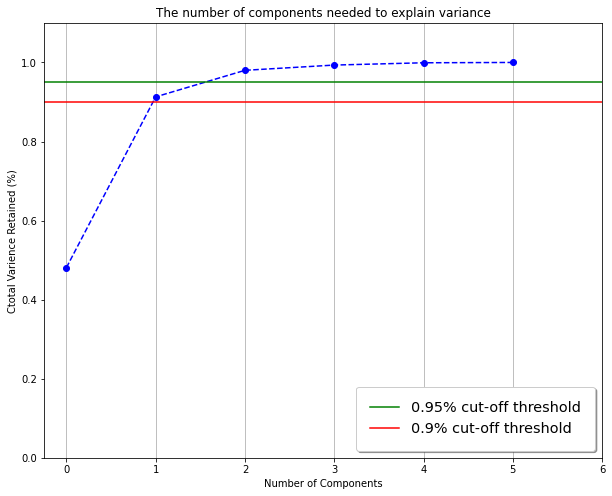

In [338]:
fig, ax = plt.subplots(figsize=(10, 8))
xi = np.arange(0, 6, step=1)
y = np.cumsum(S) / np.sum(S)
plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 7, step=1))
plt.ylabel('Ctotal Varience Retained (%)')
plt.title('The number of components needed to explain variance')

upper_threshold = 0.95
lower_threshold = 0.90

plt.axhline(y=upper_threshold, color='g', linestyle='-', label=f"{upper_threshold}% cut-off threshold")
plt.axhline(y=lower_threshold, color='r', linestyle='-', label=f"{lower_threshold}% cut-off threshold")

ax.grid(axis='x')
ax.legend(loc='lower right',shadow=True, borderpad=1, fontsize="x-large")
plt.show()

So we can see that cummulative contribution of the first two components into data variance  more than 0.9%. 

It means we can use `2` as components number. 

In [316]:
chosen_number_of_components = 2

> The @ operator can be used as a shorthand for np.matmul on ndarrays. (From numpy documentation)

In [318]:
Z_k =  U[:, :chosen_number_of_components] @ np.diag(S)[:chosen_number_of_components, :chosen_number_of_components] @ V_transposed[:chosen_number_of_components, :]

#### **Approximation Error Calculation**

In [319]:
order_norm_mapping = {
    2: "Euclidian", 
    "fro": "Frobenius",
}

In [320]:
from typing import Union
def get_approximation_error(original, approximated, order: Union[str, int]):
    appr_error = np.linalg.norm(original - approximated, ord=order)
    relative_appr_error = appr_error / np.linalg.norm(original, ord=order)
    return appr_error, relative_appr_error

In [321]:
def show_approximation_errors(original, approximated):
    for order, norm_name in order_norm_mapping.items():
        appr_error, relative_appr_error = get_approximation_error(original, approximated, order)
        print(f"Approximation Error in {norm_name} norm: {appr_error}\nRelative Approximation Error in {norm_name} norm: {relative_appr_error}\n")
        print("-"*80)

In [322]:
show_approximation_errors(Z, Z_k)

Approximation Error in Euclidian norm: 0.2530370592141687
Relative Approximation Error in Euclidian norm: 0.13962771168094706

--------------------------------------------------------------------------------
Approximation Error in Frobenius norm: 0.2588696090450704
Relative Approximation Error in Frobenius norm: 0.10568307534569857

--------------------------------------------------------------------------------


>**4. Сравнить матрицы корреляций признаков для матрицы Z и матрицы Zk. Оценить качество аппроксимации по близости матриц корреляций (можно использовать относительную погрешность в одной из матричных норм)**

In [323]:
Z_k_dataframe = pd.DataFrame(Z_k, columns=col_names)

In [324]:
Z_k_dataframe.head()

,age,n dependents,income,years in the region,car valuation,loan amount
0,0.059291,0.233093,0.342344,0.006092,0.354265,0.350001
1,0.068743,0.007040,-0.115534,0.082727,-0.110816,-0.112760
2,0.117545,0.175082,0.119877,0.094588,0.133584,0.128402
3,-0.015803,-0.110133,-0.184710,0.012176,-0.189547,-0.187864
4,-0.025232,-0.105687,-0.158325,-0.000727,-0.163622,-0.161734


Lets visualize the heatmaps difference

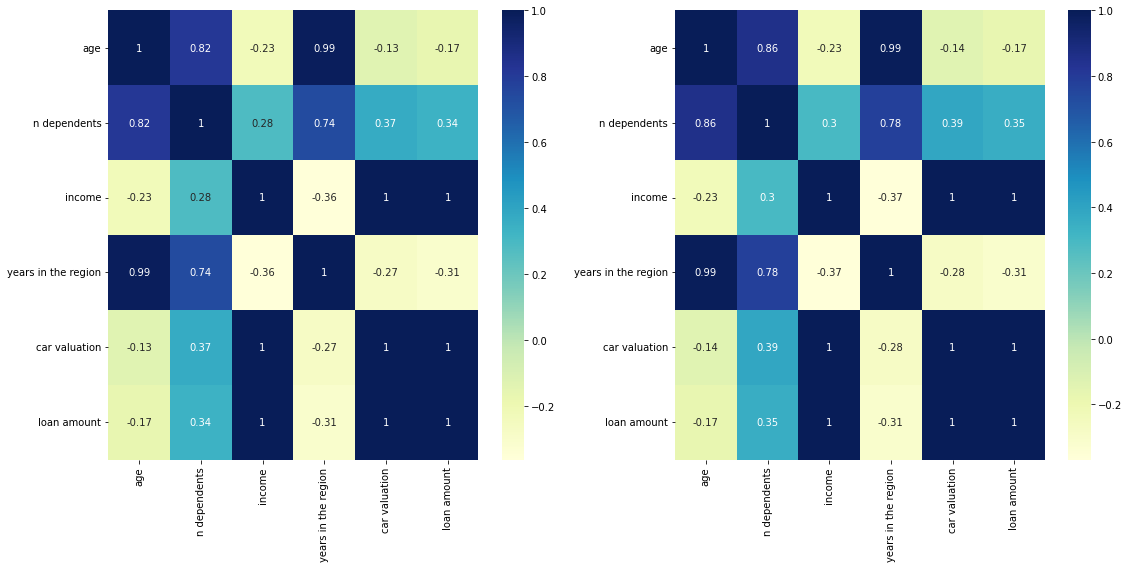

In [325]:
fig, axs = plt.subplots(ncols=2, figsize=(16, 8), )
sns.heatmap(df_normalized.corr(),annot=True,cmap="YlGnBu", ax=axs[0])
sns.heatmap(Z_k_dataframe.corr(),annot=True,cmap="YlGnBu", ax=axs[1])
fig.tight_layout()

In [326]:
show_approximation_errors(df_normalized.corr(), Z_k_dataframe.corr())

Approximation Error in Euclidian norm: 0.06791782134314575
Relative Approximation Error in Euclidian norm: 0.020680389978154027

--------------------------------------------------------------------------------
Approximation Error in Frobenius norm: 0.0915082413396804
Relative Approximation Error in Frobenius norm: 0.021685816740093202

--------------------------------------------------------------------------------


> **5. Используя выделенные главные факторы, найти представления клиентов векторами меньшей размерности (размерности k).**

>**6. Используя представление клиентов векторами меньшей размерности, построить карту клиентов. Сделать выводы о клиентах банка.**

In [327]:
principal_components = U[:, :chosen_number_of_components]

In [328]:
principal_components[:10]

array([[ 0.30364759,  0.21309591],
       [-0.12232476,  0.01759218],
       [ 0.08468095,  0.17222668],
       [-0.16745128, -0.09865008],
       [-0.14091834, -0.09634448],
       [-0.17212106, -0.24243445],
       [-0.10722907,  0.14789456],
       [ 0.01093794,  0.31345469],
       [-0.08093563,  0.15687773],
       [ 0.12147685,  0.02508195]])

In [329]:
principal_components.shape

(50, 2)

In [330]:
first_component = principal_components[:, 0]

In [331]:
second_component = principal_components[:, 1]

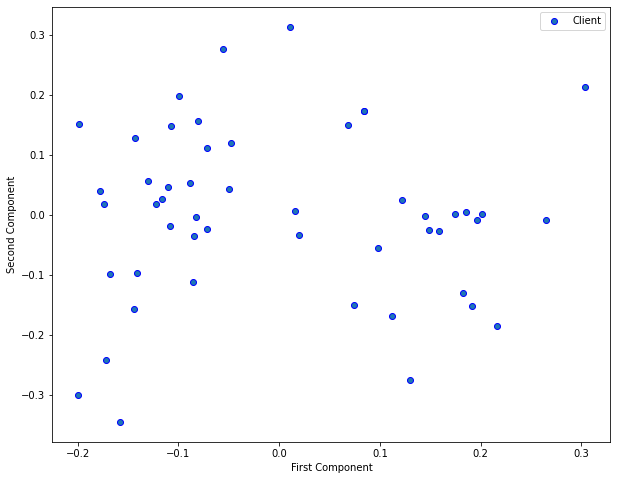

In [318]:
plt.figure(figsize=(10,8))
plt.scatter(first_component, second_component, label='Client', edgecolors='blue')
plt.legend()
plt.ylabel('Second Component')
plt.xlabel('First Component')
plt.show()

In [335]:
np.transpose(V_transposed[:chosen_number_of_components, :]).shape

(6, 2)

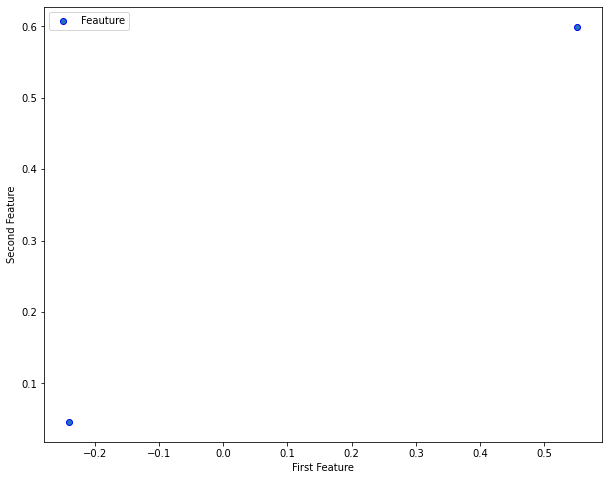

In [336]:
plt.figure(figsize=(10,8))
plt.scatter(np.transpose(V_transposed[:chosen_number_of_components, :])[0], np.transpose(V_transposed[:chosen_number_of_components, :])[1], label='Feauture', edgecolors='blue')
plt.legend()
plt.ylabel('Second Feature')
plt.xlabel('First Feature')
plt.show()

**Lets check if we can cluster clients on clients map**

How many clusters should we use? For the k-means clustering method, the most common approach for answering this question is the so-called **elbow method**.

> Inertia: It is the sum of squared distances of samples to their closest cluster center.

In [337]:
from sklearn.metrics import silhouette_score

In [338]:
#Finding the optimal K using the elbow method
sum_of_squared_distances = []
silhoute = []
K = range(1,10)
for k in K:
    km = KMeans(n_clusters=k,init='random')
    km = km.fit(principal_components)
    if k != 1:
        labels_test = km.predict(principal_components)
        silhoute.append(silhouette_score(principal_components, labels_test))
    sum_of_squared_distances.append(km.inertia_)
silhoute.insert(0,0)

So, bend of the elbow at 3 or 4 clusters, so likeky these numbers that we will be use. But let's double check ourselves.

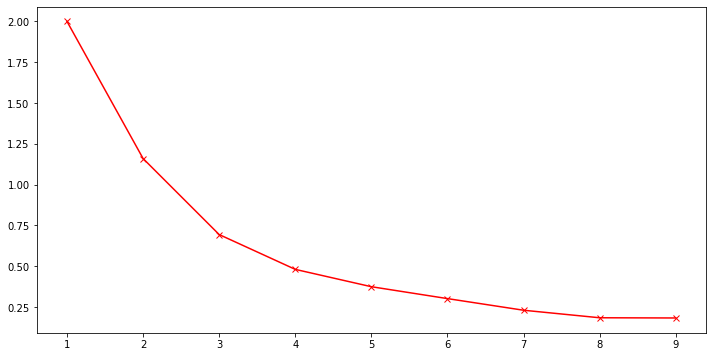

In [307]:
plt.plot(K, sum_of_squared_distances, 'rx-')

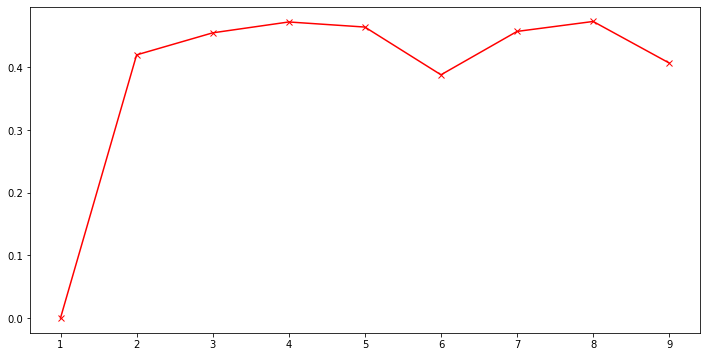

In [308]:
plt.plot(K, silhoute, 'rx-')

The mean silhouette coefficient increases up to the point when k=4 and then decreases for k=5 , adding to this information from the elbow method, i.e. it exhibits a clear peak at **k=4**, which is the number of clusters that we will be use.

In [315]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4)
kmeans.fit(principal_components)
y_kmeans = kmeans.predict(principal_components)

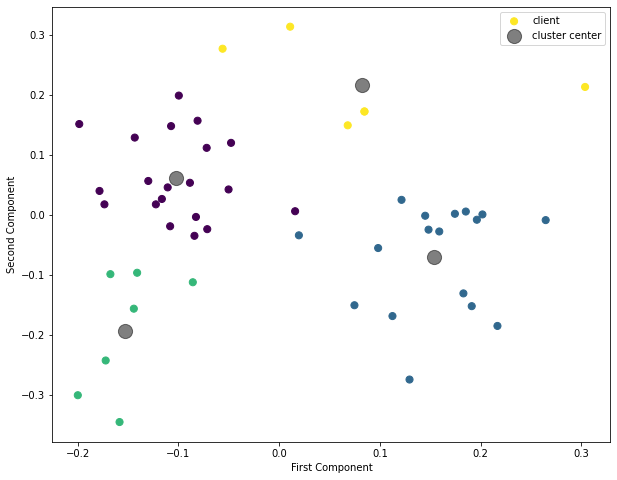

In [317]:
plt.figure(figsize=(10,8))
plt.scatter(first_component, second_component, c=y_kmeans, s=50, cmap='viridis',
            label='client')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5,
           label='cluster center')
plt.ylabel('Second Component')
plt.xlabel('First Component')
plt.legend(loc='upper right')

It is clear that we can cluster clients on clients map build with principal components.

# 3. Latent Factors Interpratation

>Выписать матрицу коэффициентов разложения признаков zj по главным факторам. Исследовать структуру этой матрицы с целью выделения групп признаков тесно связанных с каждым из главных факторов.

>На основе анализа структуры матрицы коэффициентов разложения, предложить интерпретацию выделенным главным факторам.

>Дать интерпретацию построенной выше карте клиентов.

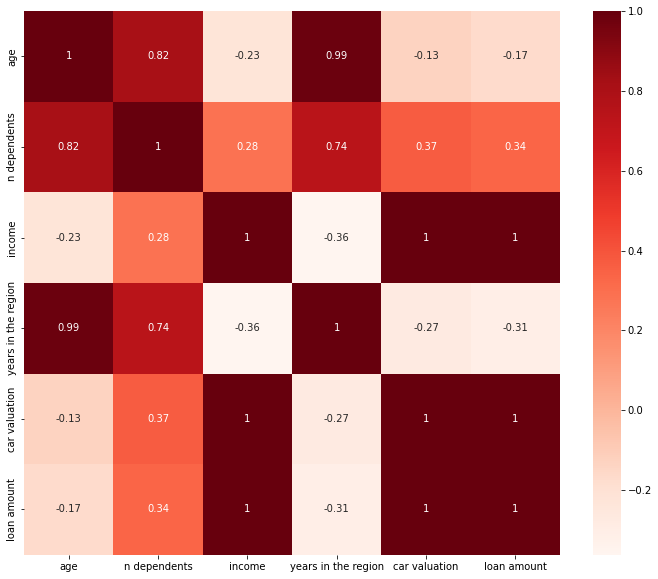

In [382]:
draw_corr_mat(df_normalized)

In [319]:
col_names

['age',
 'n dependents',
 'income',
 'years in the region',
 'car valuation',
 'loan amount']

In [278]:
pd.DataFrame(svd_coefficients[:chosen_number_of_components, :])

,0,1,2,3,4,5
0,-0.433182,0.082790,0.975605,-0.557856,0.950266,0.961067
1,0.895491,0.975872,0.216354,0.823495,0.308399,0.273002


We can notice that **u_1**  has correlation with 2, 4, 5 main factors. 

So, it represents clients financional condition. As we can see at the main factors correlation matrix above: **income**(2), **car valuation**(4) and **loan amount**(5) has very string positive correlation. And it is prove the fact that they are presented in one latent factor.

Also, logically we can interpret the negative correlation between **u_1** and **age** and **years in the region** because the younger you are, the more debts you have to pay.

And we can conclude that **u_2** represent time dependent charasteristics such as **age** and **years in the region**.

> Выполнить вращения в пространстве главных факторов с целью улучшения структуры матрицы коэффициентов разложения признаков zj по главным факторам. В случае улучшения структуры, найти новое представление клиентов векторами меньшей размерности (размерности k). Построить улучшенную карту клиентов и дать ее интерпретацию.

In [390]:
theta = np.radians(60)

G = np.array(( (np.cos(theta), -np.sin(theta)),
               (np.sin(theta),  np.cos(theta)) ))

In [391]:
G

array([[ 0.5      , -0.8660254],
       [ 0.8660254,  0.5      ]])

In [353]:
np.degrees(np.arccos(0.71))

44.765084671328424

In [327]:
principal_components.shape

(50, 2)

In [370]:
U[:, :chosen_number_of_components].shape

(50, 2)

In [392]:
Z_k_rotated = (U[:, :chosen_number_of_components] @ G)  @ (np.transpose(G) @ svd_coefficients[:chosen_number_of_components, :])

In [386]:
Z_k_rotated.shape

(50, 6)

In [387]:
pd.DataFrame(Z_k_rotated[:, :chosen_number_of_components]).head()

,0,1
0,0.059291,0.233093
1,0.068743,0.007040
2,0.117545,0.175082
3,-0.015803,-0.110133
4,-0.025232,-0.105687


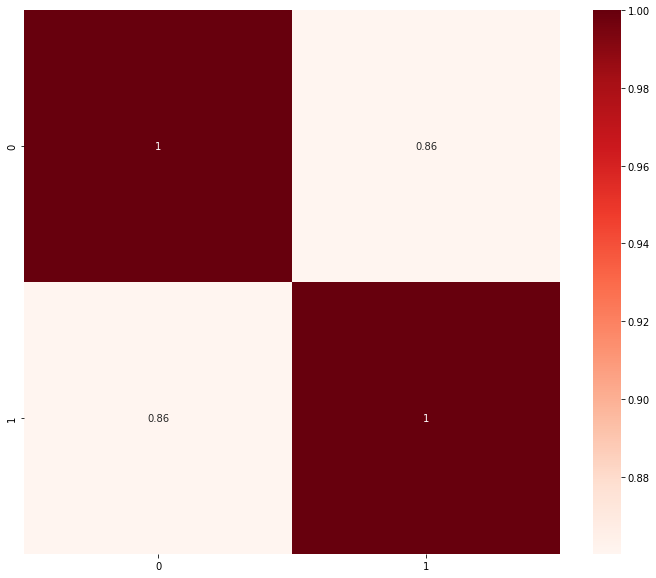

In [393]:
draw_corr_mat(pd.DataFrame(Z_k_rotated[:, :chosen_number_of_components]))

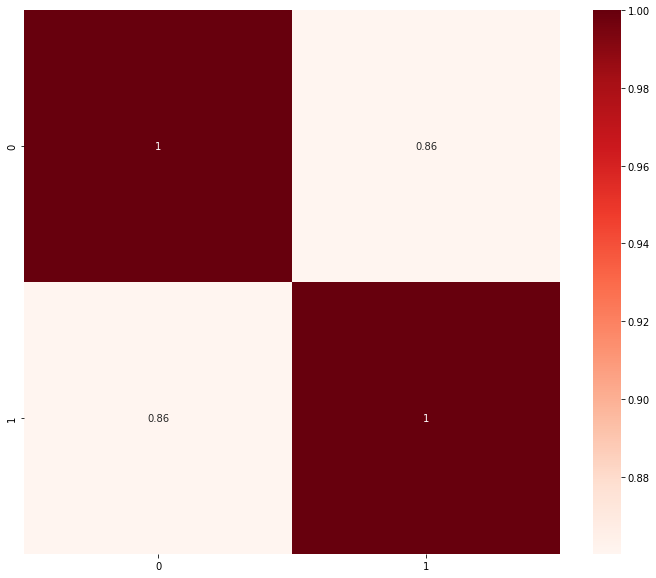

In [394]:
draw_corr_mat(pd.DataFrame(Z_k[:, :chosen_number_of_components]))

In [395]:
# Comparison load matrixes

In [363]:
pd.DataFrame((np.transpose(G) @ svd_coefficients[:chosen_number_of_components, :]))

,0,1,2,3,4,5
0,0.558927,0.886525,0.675170,0.434239,0.742214,0.716960
1,0.822892,0.416238,-0.736722,0.894865,-0.668755,-0.695808


In [360]:
pd.DataFrame(svd_coefficients[:chosen_number_of_components, :])

,0,1,2,3,4,5
0,-0.433182,0.082790,0.975605,-0.557856,0.950266,0.961067
1,0.895491,0.975872,0.216354,0.823495,0.308399,0.273002


# 4. Dimension reduction with MDS

>**1. Предложите способ вычисления расстояния между клиентами и вычислите матрицу расстояний.**

**We used 4 distance metrics - Euclidean, Manhatta, Chebyshev and Minkowski**

>**2. Проверьте, можно ли клиентов банка поместить в евклидово пространство размерности 2 с сохранением расстояний между клиентами.**

**Check that matrix $B=-\frac{1}{2}(I_n - \frac{1}{n}J_n)D^2(I_n - \frac{1}{n}J_n)$ is non-negative definite**

**Used euclidean distance**

In [353]:
dist = DistanceMetric.get_metric('euclidean')
dist_matrix = dist.pairwise(df_normalized)
dist_matrix_squared = np.zeros((n, n))
n = len(df_normalized.columns)

for i in range(n):
    for j in range(n):
        dist_matrix_squared[i,j] = dist_matrix[i,j] * dist_matrix[i,j]
        
B = -1/2 * (np.eye(n) - 1/n * np.ones(n)) @ dist_matrix_squared @ (np.eye(n) - 1/n * np.ones(n))

print("B:\n", B)

check = np.all((np.linalg.eigvals(B)).round(3)) >= 0.0
print("B is non-negative definite", check)

B:
 [[ 0.51401258 -0.0819114   0.23575441 -0.20296108 -0.17276557 -0.29212894]
 [-0.0819114   0.02620251 -0.02344815  0.03144238  0.02393092  0.02378374]
 [ 0.23575441 -0.02344815  0.13186593 -0.09547979 -0.0837065  -0.1649859 ]
 [-0.20296108  0.03144238 -0.09547979  0.08046013  0.06852552  0.11801284]
 [-0.17276557  0.02393092 -0.0837065   0.06852552  0.05917985  0.10483577]
 [-0.29212894  0.02378374 -0.1649859   0.11801284  0.10483577  0.21048249]]
B is non-negative definite True


**So, we can place the banks clients in a Euclidean space of dimension 2 with keeping the distances between clients.**

>**3. используйте любой из алгоритмов MDS для размещения объектов в евклидовом пространстве размерности 2. Оцените погрешность такого размещения. Постройте карту клиентов.**

In [281]:
def get_mds_clients(df, metric):
    dist = DistanceMetric.get_metric(metric)
    dist_matrix = dist.pairwise(df)
    model = MDS(n_components=2, 
                metric=True, 
                n_init=4, 
                max_iter=300, 
                verbose=0, 
                eps=0.001, 
                n_jobs=None, 
                random_state=42, 
                dissimilarity='precomputed')
    
    df_mds_2d = model.fit_transform(dist_matrix)

    print('The new shape of X: ',df_mds_2d.shape)
    print('Stress: ', model.stress_)
    
    return df_mds_2d

### Euclidian distances

In [282]:
mds_euclidian = get_mds_clients(df_normalized, 'euclidean')

The new shape of X:  (50, 2)
Stress:  0.07034945678698476


### Manhattan distances

In [287]:
mds_manhattan = get_mds_clients(df_normalized, 'manhattan')

The new shape of X:  (50, 2)
Stress:  5.372847575672112


### Chebyshev distances

In [288]:
mds_chebyshev = get_mds_clients(df_normalized, 'chebyshev')

The new shape of X:  (50, 2)
Stress:  0.5928652436564958


### Minkowski distances

In [289]:
mds_minkowski = get_mds_clients(df_normalized, 'minkowski')

The new shape of X:  (50, 2)
Stress:  0.07034945678698476


**Using of Euclidean and Minkowski metrics of distanse gave the min of stress function**

### Clients map visualization

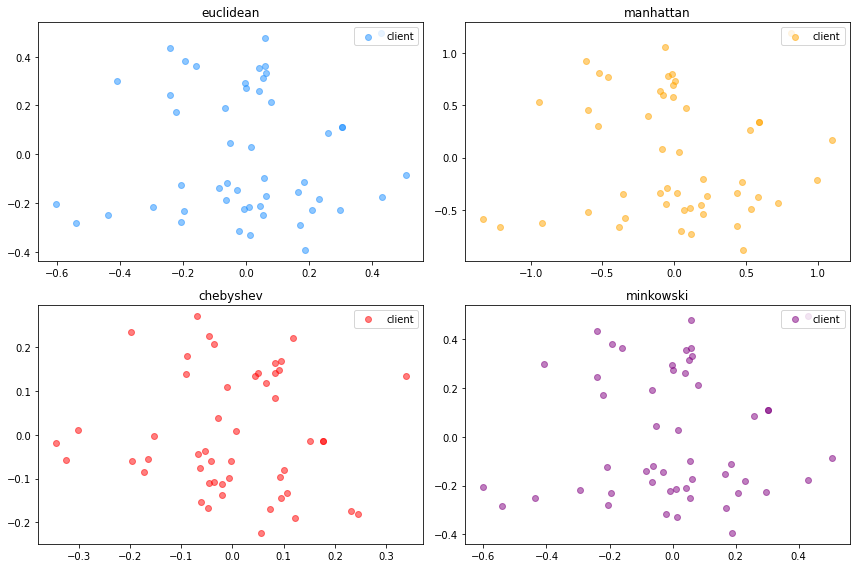

In [295]:
X = [mds_euclidian, mds_manhattan, mds_chebyshev, mds_minkowski]
titles = ['euclidean', 'manhattan', 'chebyshev', 'minkowski']
draw_client_map(X, titles)

**Visually customer cards are almost the same**

### Clients clustering

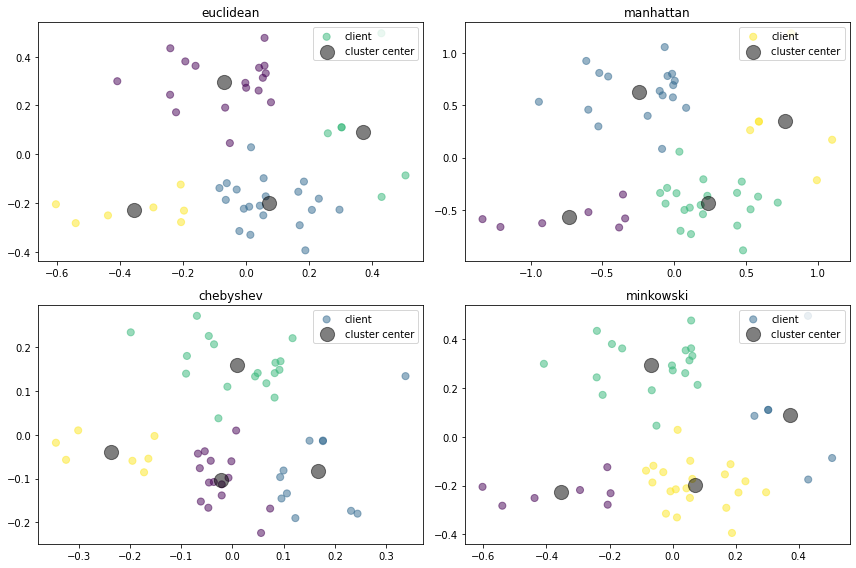

In [297]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
for x, ax, title in zip(X, axes.flat, titles):
    kmeans = KMeans(n_clusters=4)
    kmeans.fit(x)
    clusters = kmeans.predict(x)
    ax.scatter(x[:,0], x[:, 1], c=clusters, s=50, cmap='viridis',
               alpha=0.5, marker='o', label='client')
    
    centers = kmeans.cluster_centers_
    ax.scatter(centers[:, 0], centers[:, 1],
                c='black', s=200, alpha=0.5, label='cluster center')
    
    ax.legend(loc='upper right')
    ax.set_title(title)
plt.tight_layout()


**Сlusters are also similar when using different metrics. However, clusters getting with the Chebyshev metric are different from others**

>**4. Сравните с картами клиентов из предыдущих пунктов и сделайте выводы.**